In [74]:
import os
import re
import requests
import zipfile
from urllib.request import urlopen
from io import BytesIO
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns

- access the person file from each year
- calculate total fatalities for each group for each year and add to new dataframe
- calculate relative fatalities for each group for each year and add to new dataframe

- split by race?

In [2]:
# list of years for later use
yr_range = [x for x in range(1975, 2021)]

person_names = [
    "person.csv",
    "person.CSV",
    "PERSON.csv",
    "PERSON.CSV",
    "Person.CSV",
    "Person.csv"
]

# create a list of paths to access the FARS FTP site
paths = [
    "https://static.nhtsa.gov/nhtsa/downloads/FARS/" + 
    str(x) + 
    "/National/FARS" + 
    str(x) + 
    "NationalCSV.zip" for x in yr_range
]

# check
paths[10]

'https://static.nhtsa.gov/nhtsa/downloads/FARS/1985/National/FARS1985NationalCSV.zip'

In [70]:
def find_filename(name_list, file_list):
    """
    Output the exact name of a file by checking
    against a predefined list of filenames. Used to
    deal with different filename cases across years
    in FARS data.
    
    - name_list: predefined list of names
    - file_list: list of file names to search through
    """
    filename = "None" # initialize a filename variable
    
    # run through list of files
    for file in file_list:
        if file in name_list: # check if list of file is in predefined list
            filename = file # if so, set filename
    if filename == "None": # if not, raise error
        raise ValueError(
            'There were no matches between the predefined list {} and list {}'.format(name_list, file_list))
        
    return filename

def fetch_multi_csv_zip_from_url(url, filenames=[], *args, **kwargs):
    """
    Modified from:
    https://stackoverflow.com/questions/48843761/how-to-scrape-csv-
    files-from-a-url-when-they-are-saved-in-a-zip-file-in-pytho
    """
    assert kwargs.get('compression') is None
    
    req = urlopen(url)
    
    zip_file = zipfile.ZipFile(BytesIO(req.read()))
    
    names = zip_file.namelist() # get a list of files in the archive
    filename = find_filename(filenames, names) # find the right filename
    
    # check that the specified file names are actually in the zip
    if filename not in names:
        raise ValueError(
            'filename {} not in {}'.format(filename, names))
    
    # read the file into a dataframe
    df = pd.read_csv(zip_file.open(filename), *args, **kwargs)
    return df


def remap_PER_TYP(person_file, year):
    """
    This function remaps values in the person.csv file's
    PER_TYPE column across all years in NHTSA's Fatality 
    Analysis and Reporting System (FARS). The remapped
    values are based on the table on C-40 (PDF p.565) of
    the 2022 User Manual. Input:
    
     - person_file: a dataframe of the person.csv file
     - year: numeric value of the year the file is from
    
    """
    per_typ_75_81 = {
        1: "Driver",
        2: "Passenger",
        9: "Passenger",
        5: "Other non-occupant",
        3: "Pedestrian",
        4: "Bicyclist", # changed from pedalcyclist
        8: "Other/unknown non-occupant"
    }

    per_typ_82_93 = {
        1: "Driver",
        2: "Passenger",
        9: "Passenger",
        3: "Other non-occupant",
        4: "Other non-occupant",
        5: "Pedestrian",
        6: "Bicyclist", # changed from pedalcyclist
        7: "Bicyclist", # changed from pedalcyclist
        8: "Other/unknown non-occupant"
    }

    per_typ_94_04 = {
        1: "Driver",
        2: "Passenger",
        9: "Passenger",
        3: "Other non-occupant",
        4: "Other non-occupant",
        5: "Pedestrian",
        6: "Bicyclist", # changed from pedalcyclist
        7: "Bicyclist", # changed from pedalcyclist
        8: "Other non-occupant",
        19: "Unknown non-occupant type",
        99: "Unknown person type"
    }

    per_typ_05_06 = {
        1: "Driver",
        2: "Passenger",
        9: "Passenger",
        3: "Other non-occupant",
        4: "Other non-occupant",
        5: "Pedestrian",
        6: "Bicyclist", # changed from pedalcyclist
        7: "Bicyclist", # changed from pedalcyclist
        8: "Other non-occupant",
        19: "Unknown non-occupant type",
    }

    per_typ_07_19 = {
        1: "Driver",
        2: "Passenger",
        9: "Passenger",
        3: "Other non-occupant",
        4: "Other non-occupant",
        5: "Pedestrian",
        6: "Bicyclist", # changed from pedalcyclist
        7: "Bicyclist", # changed from pedalcyclist
        8: "Other non-occupant",
        10: "Other non-occupant",
        19: "Unknown non-occupant type",
        88: "Unknown person type"
    }

    per_typ_20_plus = {
        1: "Driver",
        2: "Passenger",
        9: "Passenger",
        3: "Other non-occupant",
        4: "Other non-occupant",
        5: "Pedestrian",
        6: "Bicyclist", # changed from pedalcyclist
        7: "Bicyclist", # changed from pedalcyclist
        8: "Other non-occupant",
        10: "Other non-occupant",
        11: "Other non-occupant",
        12: "Other non-occupant",
        13: "Other non-occupant",
        19: "Unknown non-occupant type",
    }
    
    
    df = person_file.copy()
    """
    if year in range(1975, 1982):
        person_file.loc[:, "PER_TYP"].replace(to_replace=per_typ_75_81, inplace=True)
    elif year in range(1982, 1994):
        person_file["PER_TYP"].replace(to_replace=per_typ_82_93, inplace=True)
    elif year in range(1994, 2005):
        person_file["PER_TYP"].replace(to_replace=per_typ_94_04, inplace=True)
    elif year in range(2005, 2007):
        person_file["PER_TYP"].replace(to_replace=per_typ_05_06, inplace=True)
    elif year in range(2007, 2020):
        person_file["PER_TYP"].replace(to_replace=per_typ_07_19, inplace=True)
    else:
        person_file["PER_TYP"].replace(to_replace=per_typ_20_plus, inplace=True) # may need to modified annually
    """
    if year in range(1975, 1982):
        df.loc[:, "PER_TYP"].replace(to_replace=per_typ_75_81, inplace=True)
    elif year in range(1982, 1994):
        df["PER_TYP"].replace(to_replace=per_typ_82_93, inplace=True)
    elif year in range(1994, 2005):
        df["PER_TYP"].replace(to_replace=per_typ_94_04, inplace=True)
    elif year in range(2005, 2007):
        df["PER_TYP"].replace(to_replace=per_typ_05_06, inplace=True)
    elif year in range(2007, 2020):
        df["PER_TYP"].replace(to_replace=per_typ_07_19, inplace=True)
    else:
        df["PER_TYP"].replace(to_replace=per_typ_20_plus, inplace=True) # may need to modified annually
    
    return  df #person_file

In [49]:
dfs = {} # initialize dictionary to hold dfs of person.csv

for i in range(len(yr_range)):
    # url to data on NHTSA FTP site
    url = paths[i]
    # get function to retrieve CSV file from ZIP
    df = fetch_multi_csv_zip_from_url(
        url, 
        filenames=person_names, 
        encoding_errors="surrogateescape", # deal with encoding errors
        low_memory=False # deal with multiple dtypes in one column
    )
    # add year and df of person.csv as 
    # key:value pair in dict
    dfs[yr_range[i]] = df

# access df by year key
dfs[1975].head()

,STATE,COUNTY,MONTH,DAY,HOUR,MINUTE,VE_FORMS,ROAD_FNC,HARM_EV,MAN_COLL,...,P_CF3,ST_CASE,MAK_MOD,VIN_WGT,WHLBS_SH,WHLBS_LG,MCYCL_DS,DEATH_TM,VINA_MOD,SER_TR
0,1,95,1,4,22,24,3,NaN,12,2,...,0,10001,1210.0,3664.0,1140.0,0.0,NaN,0,GTS,***
1,1,95,1,4,22,24,3,NaN,12,2,...,0,10001,1899.0,9999.0,9999.0,9999.0,9999.0,0,999,999
2,1,95,1,4,22,24,3,NaN,12,2,...,0,10001,1210.0,3317.0,1160.0,0.0,NaN,9998,TGT,***
3,1,95,1,2,4,30,1,NaN,18,0,...,0,10002,2209.0,3164.0,1080.0,0.0,NaN,9998,FBD,***
4,1,95,1,2,4,30,1,NaN,18,0,...,0,10002,2209.0,3164.0,1080.0,0.0,NaN,0,FBD,***


In [71]:
df = dfs[1975]
df = df.loc[df["INJ_SEV"] == 4]
df = remap_PER_TYP(df, 1975) # remap values in the PER_TYP column


2         4
3         4
5         4
7         4
9         4
         ..
104880    4
104882    4
104883    4
104884    4
104885    4
Name: INJ_SEV, Length: 44525, dtype: int64

In [72]:
fatalities = pd.DataFrame() # initialize dataframe

for year, df in dfs.items(): # access year and associated person.csv dataframe
    df = df.loc[df["INJ_SEV"] == 4]
    df = remap_PER_TYP(df, year) # remap values in the PER_TYP column
    grouped = df.groupby("PER_TYP") # group by PER_TYP column
    count = grouped.size().reset_index() # count fatalities in each group, make into df
    count.rename(columns={0: year}, inplace=True) # rename column to year
    count = count.melt(id_vars="PER_TYP", value_vars=year, var_name="YEAR", value_name="FATALITIES") # tidy
    fatalities = pd.concat([fatalities, count]) # combine into single dataframe

In [85]:
fatalities.reset_index(inplace=True)

<AxesSubplot:xlabel='YEAR', ylabel='FATALITIES'>

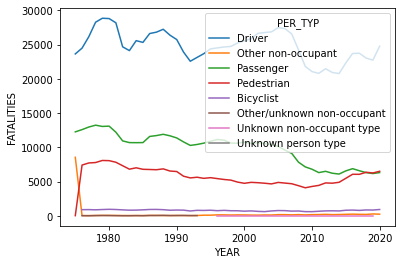

In [86]:
sns.lineplot(data=fatalities, x="YEAR", y="FATALITIES", hue="PER_TYP")